In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.integrate import simpson

In [2]:
# Constants
NA = 6.02214076E23  # Avogadro's number

In [3]:
def compute_c_profile(xvg_file):
    """
    Computes a concentration profile from an XVG file by averaging symmetric parts of the profile.

    Parameters
    ----------
    xvg_file : str
        The path to the XVG file containing the number density data.
    
    Returns
    -------
    z_coords : numpy.ndarray
        The z-coordinates of the concentration profile.
    c_profile : numpy.ndarray
        The symmetric concentration profile.
    """
    z_coords, rho = np.loadtxt(xvg_file, comments=["@", "#"], unpack=True)
    # rho = rho / NA * 1E27 / 1000  # number density in mol/L

    mid_idx = int(len(rho) / 2 - 1)
    c_profile = 0.5 * (rho[:mid_idx + 1][::-1] + rho[mid_idx:-1])  # in mol/L
    z_coords = z_coords[:mid_idx + 1]  # in nm

    return z_coords, c_profile


## Plotting initial concentration profiles

In [4]:
# all Z's are the same! Just call it z.

In [5]:
z, c_original = compute_c_profile("density_hw_original_288.xvg")
z_1, c_1 = compute_c_profile("density_hw_r1_288.xvg")  # replicate 1
z_2, c_2 = compute_c_profile("density_hw_r2_288.xvg")  # replicate 2
z_3, c_3 = compute_c_profile("density_hw_r3_288.xvg")  # replicate 3


In [6]:
# Example concentration profiles
concentration_profiles = np.array([c_original,c_1,c_2,c_3])

Note: I think it is somewhat more rigorous to normalize the densities, since we know what the total number must be. This eliminated one source of error 

In [7]:
# Estimate the total number of ions, N_s (using Equation 13)
L_x, L_y, L_z = 4.8, 4.8, 14.4
Ntrue = 188
for c in concentration_profiles:
    N_s = L_x * L_y * simpson(c, z)
    print(N_s)  # this should be around 188
    c /= (N_s/Ntrue)
# verify normalization worked.
for c in concentration_profiles:
    N_s = L_x * L_y * simpson(c, z)
    print(N_s)  # this should be around 188
    

188.00496817343995
188.18428364160002
187.98510751343997
188.10112932479998
188.00000000000006
187.99999999999997
188.00000000000006
188.00000000000006


/tmp/ipykernel_125479/2150603121.py:5: DeprecationWarning: You are passing x=[0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075 1.125 1.175
 1.225 1.275 1.325 1.375 1.425 1.475 1.525 1.575 1.625 1.675 1.725 1.775
 1.825 1.875 1.925 1.975 2.025 2.075 2.125 2.175 2.225 2.275 2.325 2.375
 2.425 2.475 2.525 2.575 2.625 2.675 2.725 2.775 2.825 2.875 2.925 2.975
 3.025 3.075 3.125 3.175 3.225 3.275 3.325 3.375 3.425 3.475 3.525 3.575
 3.625 3.675 3.725 3.775 3.825 3.875 3.925 3.975 4.025 4.075 4.125 4.175
 4.225 4.275 4.325 4.375 4.425 4.475 4.525 4.575 4.625 4.675 4.725 4.775
 4.825 4.875 4.925 4.975 5.025 5.075 5.125 5.175 5.225 5.275 5.325 5.375
 5.425 5.475 5.525 5.575 5.625 5.675 5.725 5.775 5.825 5.875 5.925 5.975
 6.025 6.075 6.125 6.175 6.225 6.275 6.325 6.375 6.425 6.475 6.525 6.575
 6.625 6.675 6.725 6.775 6.825 6.875 6.925 6.975 7.025 7.075 7.125 7.175] as a positional argument. Please change your i

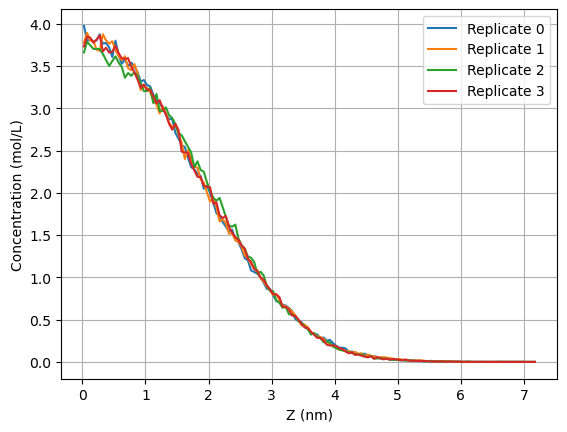

In [8]:
# Plot the concentration profiles
plt.figure()
for i, c in enumerate(concentration_profiles):
    plt.plot(z, c, label="Replicate "+str(i))
plt.xlabel("Z (nm)")
plt.ylabel("Concentration (mol/L)")
plt.grid()
plt.legend()
plt.show()

## Bootstrapping concentration profiles

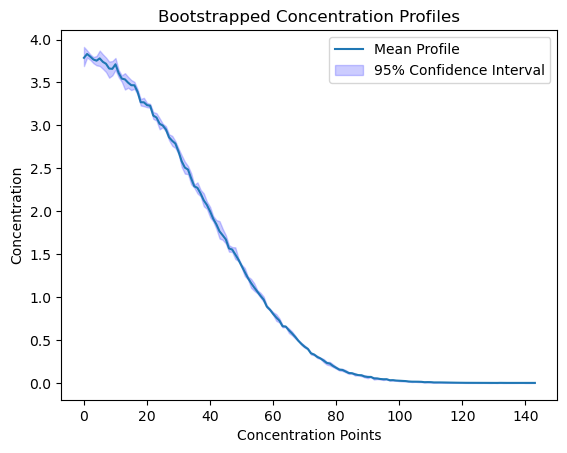

In [9]:
# Example concentration profiles
concentration_profiles = [c_original,c_1,c_2,c_3]

# Number of bootstrap samples
n_bootstrap = 1000

# Function to perform bootstrapping
def bootstrap_profiles(profiles, n_samples):
    bootstrap_means = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        bootstrap_means.append(mean_profile)
    return np.array(bootstrap_means)

# Perform bootstrapping
bootstrap_means = bootstrap_profiles(concentration_profiles, n_bootstrap)

# Calculate the mean and 95% confidence intervals for each point
#mean_profile = np.mean(bootstrap_means, axis=0)

#Bbetter to use the direct average rather than over bootstrap means
mean_profile = np.mean(concentration_profiles,axis=0)
lower_bound = np.percentile(bootstrap_means, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_means, 97.5, axis=0)

c_0 = mean_profile
# Plotting the results
conc_points = range(len(c_0))
plt.plot(conc_points, c_0, label='Mean Profile')
plt.fill_between(conc_points, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Concentration Points')
plt.ylabel('Concentration')
plt.legend()
plt.title('Bootstrapped Concentration Profiles')
plt.show()

/tmp/ipykernel_125479/2730136378.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(z, np.log(c_0), label='Mean Profile')


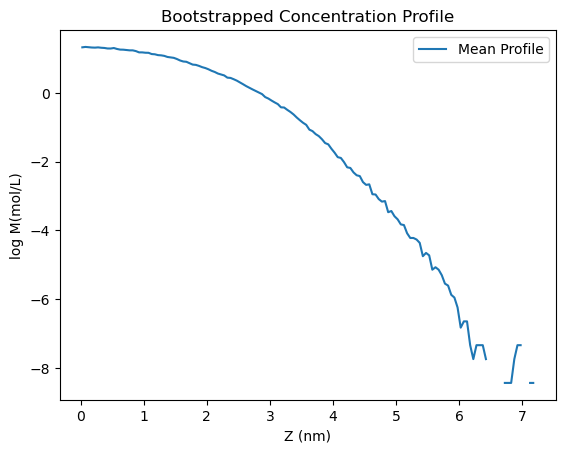

In [10]:
# Plotting the results
plt.plot(z, np.log(c_0), label='Mean Profile')
plt.xlabel('Z (nm)')
plt.ylabel('log M(mol/L)')
plt.legend()
plt.title('Bootstrapped Concentration Profile')
plt.show()

In [11]:
def calc_y(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    B, alpha_1, alpha_2 = theta[0], theta[1], theta[2]  # all nm-based
    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    term_2 = A * np.sqrt(C_max) / (1 + B * np.sqrt(C_max))
    term_3 = -A * np.sqrt(x) / (1 + B * np.sqrt(x))
    term_4 = (alpha_1 * (x - C_max)) + (alpha_2 * (x ** 2 - C_max ** 2))

    y = term_1 + term_2 + term_3 + term_4

    return y

def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

In [12]:
# I don't think you need this function? There are no parameters in the ideal solution.
def y_ideal(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    B, alpha_1, alpha_2 = theta[0], theta[1], theta[2]  # all nm-based
    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    # term_2 = A * np.sqrt(C_max) / (1 + B * np.sqrt(C_max))
    # term_3 = -A * np.sqrt(x) / (1 + B * np.sqrt(x))
    # term_4 = (alpha_1 * (x - C_max)) + (alpha_2 * (x ** 2 - C_max ** 2))

    return term_1

def residuals_ideal(theta, x, y):
    return np.power(y_ideal(theta, x) - y, 2)

In [13]:
# Removing 0 values from the concentration profile, and the corresponding z values
z_fit = z[c_0 != 0]
c_fit = c_0[c_0 != 0]

In [14]:
# Calculating -U(z) / RT (y_values below)
k = 1.0457  # units: kJ/mol/nm^2
R = 8.31446261815324  # units: J/(mol*K)
T = 300  # units: K
y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T)

#Getting fit for full left side of eq 12
result = least_squares(residuals, [0.1, 0.1, 0.1], args=(c_fit, y_values))

#Getting fit for ideal part of eq 12 ln(c(z)/cmax)
#result_ideal = least_squares(residuals_ideal, [2, 0.1, 0.3], args=(c_0, y_values))

In [15]:
unweighted_result = result

In [16]:
#Function to get fitted theta values
def get_results(result_fit):
    result=result_fit
    # B, alpha_1, and alpha_2 have units of [nm^(-3)]^(-1/2), [nm^(-3)]^(-1), and [nm^(-3)]^(-2)
    B, alpha_1, alpha_2 = result.x[0], result.x[1], result.x[2]
    # Converting nm^(-3) to mol/L for the three parameters
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    B *= (conversion_factor ** (-0.5))  # units M^(-1/2)
    alpha_1 *= (conversion_factor ** (-1))  # units M^(-1)
    alpha_2 *= (conversion_factor ** (-2))  # units M^(-2)
    print("B=",B,'alpha1=',alpha_1,'alpha2=', alpha_2)
    newtheta=(B, alpha_1, alpha_2)
    #print(result.x)
    #print(result.cost)
    #print(result.optimality)
    return newtheta

In [17]:
newtheta=get_results(result)

B= 10026.840827249618 alpha1= -0.05961175594256452 alpha2= 0.01548422855172517


In [18]:
# # Alirezza SI nm-based answers
# print(1.9247 / (conversion_factor ** (-0.5)))
# print(9.3393E-2 / (conversion_factor ** (-1)))
# print(3.4572E-2 / (conversion_factor **(-2)))

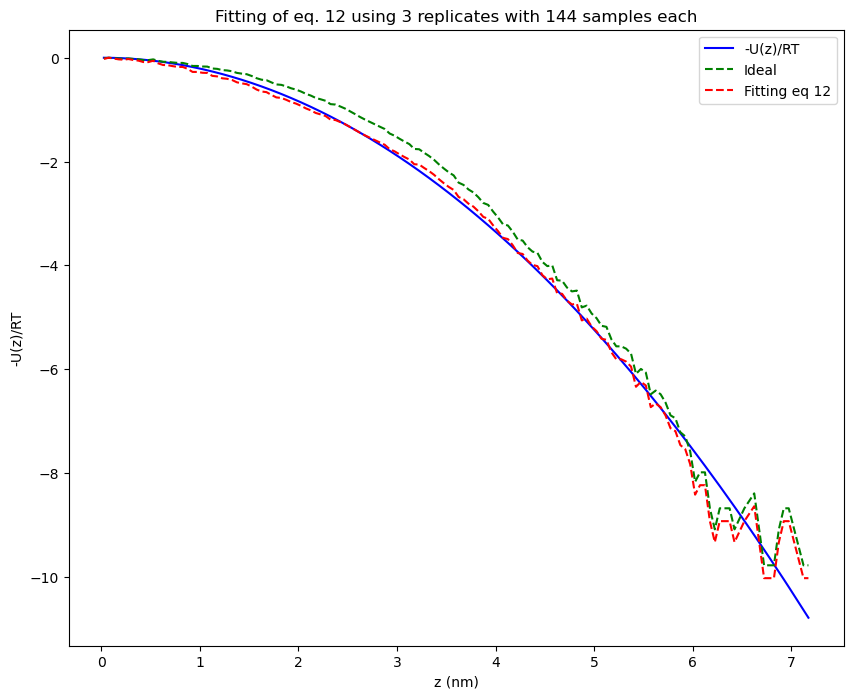

In [19]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
#plt.plot(z, calc_y(idealtheta,c_0), 'g--', label="Ideal")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
# we want the direct output of results plotted here, not the rescaled ones.
plt.plot(z_fit, calc_y(result.x,c_fit), 'r--', label="Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

We do see reasonably good fit - the idea curve (green line) is corrected to the be closer to the blue (red line is closer tothe blue line). However, we would also like to not fit the noise at the end. 

To do this, we do some error propagation to find the ideal weights for the least square fit. $C(z)/C_{max}$ is a probability, or at least proportional to a probability.  The uncertainty in a probability estimate $\hat{p}$ from a histogram (whose value with infinitely collected points would be $p$), can be shown to be $\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$, where $\hat{p}$ is the measured probability in that histogram bin, and $n$ is the total number of points collected over all bins.  But we are interested in the error of $\ln \hat{p}$. Generally the error in function $f$ of random variable $x$ $\delta f(x)$ is equal to $\abs{f'(x)}\delta x$. So $\delta (\ln p) = \frac{\delta p}{p} = \sqrt{\frac{\hat{p}(1-\hat{p})}{n\hat{p}^2}}$.

For weighted least squares, it can be show that the weights should be proportional to 1/variance of the data point. The variance will be $(\delta\ln p)^2 = \frac{\hat{p}(1-\hat{p})}{n\hat{p}^2} = \frac{1-\hat{p}}{np}$.  The weights are only defined up to a constant, so we can just use $\frac{1-p}{p}$.  To do this, we have to normalize $C/C_{max}$, which is easy to do, we call it K. So the weights should be proportional to $\frac{C/K}{1-C/K} = \frac{C}{K-C}$.  So the most well defined points will get the most probability, the noisiest points the least.

In [20]:
norm = simpson(c, z)

/tmp/ipykernel_125479/4274661485.py:1: DeprecationWarning: You are passing x=[0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075 1.125 1.175
 1.225 1.275 1.325 1.375 1.425 1.475 1.525 1.575 1.625 1.675 1.725 1.775
 1.825 1.875 1.925 1.975 2.025 2.075 2.125 2.175 2.225 2.275 2.325 2.375
 2.425 2.475 2.525 2.575 2.625 2.675 2.725 2.775 2.825 2.875 2.925 2.975
 3.025 3.075 3.125 3.175 3.225 3.275 3.325 3.375 3.425 3.475 3.525 3.575
 3.625 3.675 3.725 3.775 3.825 3.875 3.925 3.975 4.025 4.075 4.125 4.175
 4.225 4.275 4.325 4.375 4.425 4.475 4.525 4.575 4.625 4.675 4.725 4.775
 4.825 4.875 4.925 4.975 5.025 5.075 5.125 5.175 5.225 5.275 5.325 5.375
 5.425 5.475 5.525 5.575 5.625 5.675 5.725 5.775 5.825 5.875 5.925 5.975
 6.025 6.075 6.125 6.175 6.225 6.275 6.325 6.375 6.425 6.475 6.525 6.575
 6.625 6.675 6.725 6.775 6.825 6.875 6.925 6.975 7.025 7.075 7.125 7.175] as a positional argument. Please change your i

In [21]:
def weighted_residuals(theta, x, y):
    return (x/(norm-x))*np.power(calc_y(theta, x) - y, 2)

In [22]:
#Getting fit for full left side of eq 12
result_weighted = least_squares(weighted_residuals, [0.1, 0.1, 0.1], args=(c_fit, y_values))

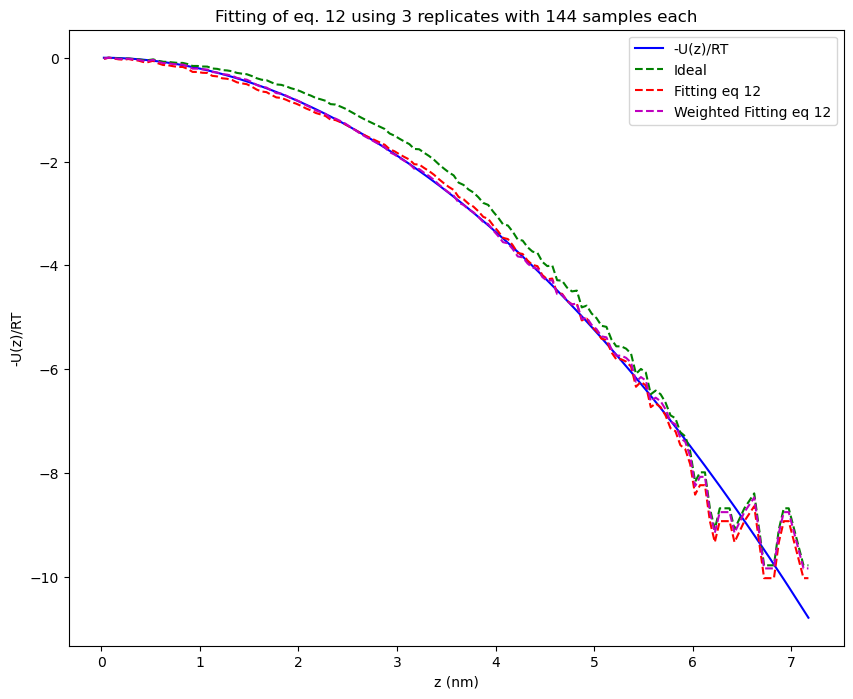

In [23]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
#plt.plot(z, calc_y(idealtheta,c_0), 'g--', label="Ideal")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
# we want the direct output of results plotted here, not the rescaled ones.
plt.plot(z_fit, calc_y(result.x,c_fit), 'r--', label="Fitting eq 12")
plt.plot(z_fit, calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

Hard to see what is going on, so let's look at differences

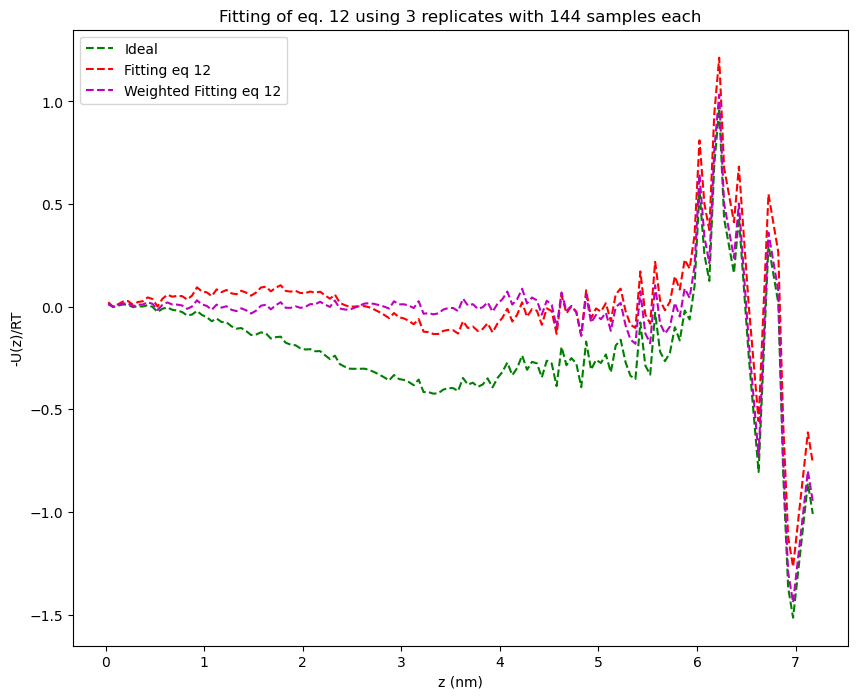

In [24]:
# plot the results
plt.figure(figsize = (10,8))
#plt.plot(z, calc_y(idealtheta,c_0), 'g--', label="Ideal")
plt.plot(z_fit, y_values-np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
# we want the direct output of results plotted here, not the rescaled ones.
plt.plot(z_fit, y_values-calc_y(result.x,c_fit), 'r--', label="Fitting eq 12")
plt.plot(z_fit, y_values-calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

The weighted fitting is much closer to zero over the range with reasonable concentrations, say z=5.

In [25]:
np.std(y_values[z_fit<5]-calc_y(result.x,c_fit[z_fit<5]))

0.06980100300793264

In [26]:
np.std(y_values[z_fit<5]-calc_y(result_weighted.x,c_fit[z_fit<5]))

0.02989622377268761

Compare the distribution of the parameters with the fit!

In [27]:
print("B =", result_weighted.x[0])
print("alpha1 =", result_weighted.x[1])
print("alpha2 =", result_weighted.x[2])

B = 1.4400944932651063
alpha1 = 0.2888290244450547
alpha2 = -0.02400426045473929


In [28]:
print("B =", result.x[0])
print("alpha1 =", result.x[1])
print("alpha2 =", result.x[2])

B = 12920.778144694781
alpha1 = -0.09898764960546111
alpha2 = 0.04269605686730636


And we expect that the parameters will be more consistent between runs with weighting.

In [29]:
# Function to perform bootstrapping
def bootstrap_profiles(profiles, n_samples, res_func):
    bootstrap_params = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        z_fit = z[mean_profile != 0]
        c_fit = mean_profile[mean_profile != 0] 
        y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T)
        result = least_squares(res_func, [0.1, 0.1, 0.1], args=(c_fit, y_values))
        bootstrap_params.append(result.x)                        
    return np.array(bootstrap_params)

Parma 0 = 1576.9861172516987 +/- 4328.525130503124


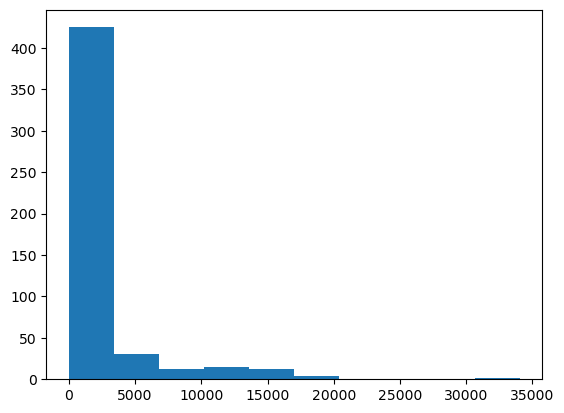

Parma 1 = 0.4120653764521107 +/- 0.3800771901160823


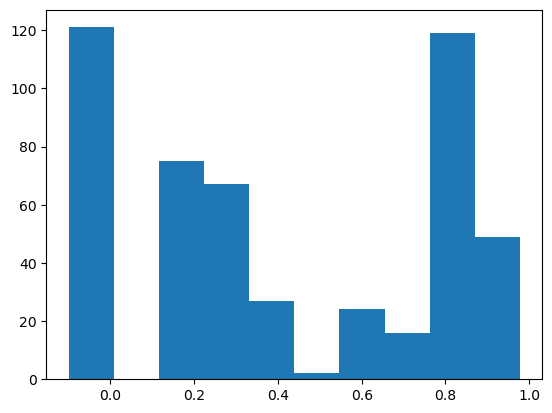

Parma 2 = -0.0250923653161328 +/- 0.043666543003168294


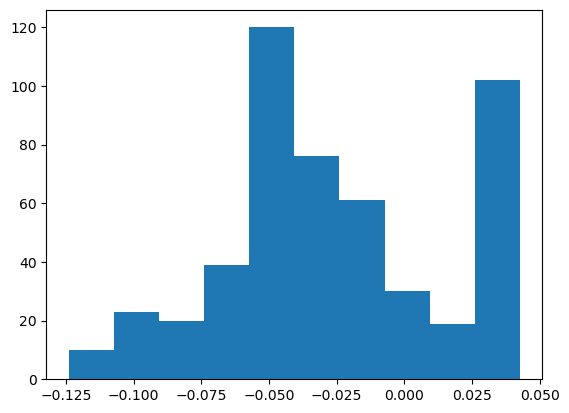

In [30]:
# Perform bootstrapping with unweighted fit
n_bootstrap = 500
bootstrap_params = bootstrap_profiles(concentration_profiles, n_bootstrap, residuals)

for i in range(3):
    pd = bootstrap_params[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parma {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Parma 0 = 1.345544277299619 +/- 0.6239036455664587


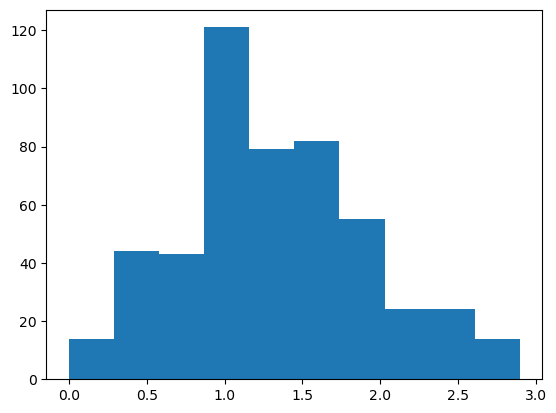

Parma 1 = 0.35254887564114523 +/- 0.12400251442944075


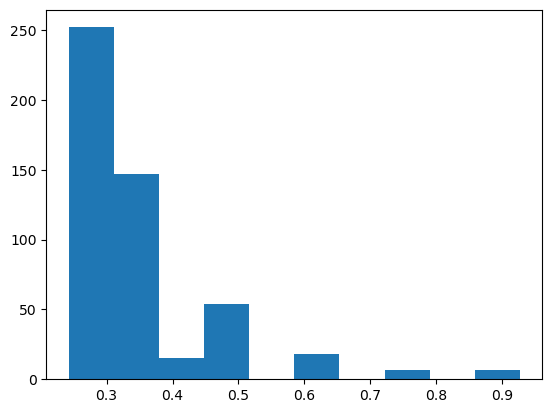

Parma 2 = -0.03131286504535901 +/- 0.010137885875233753


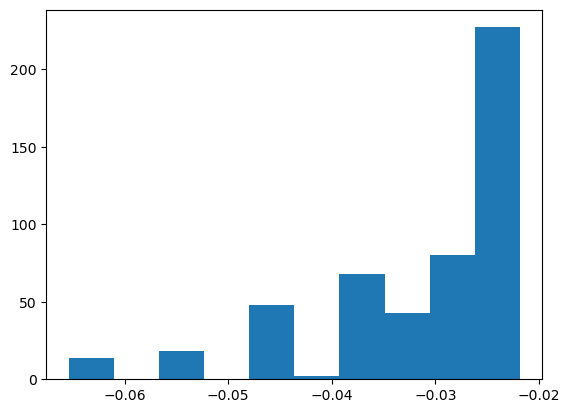

In [31]:
# Perform bootstrapping with weighted residuals
n_bootstrap = 500
bootstrap_params = bootstrap_profiles(concentration_profiles, n_bootstrap, weighted_residuals)

for i in range(3):
    pd = bootstrap_params[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parma {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Much more consistent performance!